# 자연어 처리
* 단어간의 관계
 * 시소러스
 * 통계기반
 * 추론 기반

### 시소러스 -> 수작업

## 통계 기반 기법

In [1]:
text = 'you say goobye and I say hello.'

In [2]:
text = text.lower() #소문자로
text = text.replace('.', ' .') # 점도 하나의 단어로 판별!
print(text)

you say goobye and i say hello .


In [3]:
words = text.split(' ') #단어로 분해 -> list 생성!
print(words)

['you', 'say', 'goobye', 'and', 'i', 'say', 'hello', '.']


In [6]:
word_to_id = {}
id_to_word = {}

for word in words:
    if word not in word_to_id:
        new_id = len(word_to_id) # number of words in dictionary
        word_to_id[word] = new_id # {"you": 0, "say": 1, ...}
        id_to_word[new_id] = word

In [7]:
print(word_to_id)
print(id_to_word)

{'you': 0, 'say': 1, 'goobye': 2, 'and': 3, 'i': 4, 'hello': 5, '.': 6}
{0: 'you', 1: 'say', 2: 'goobye', 3: 'and', 4: 'i', 5: 'hello', 6: '.'}


In [8]:
id_to_word[1]

'say'

In [9]:
import numpy as np
corpus = [word_to_id[w] for w in words]
corpus = np.array(corpus)
print(corpus)

[0 1 2 3 4 1 5 6]


### preprocess function : create corpus and dicts from str

In [10]:
def preprocess(text):
    text=text.lower()
    text=text.replace('.', ' .')
    words=text.split()
    word_to_id={}
    id_to_word={}

    for word in words:
        if word not in word_to_id:
            new_id=len(word_to_id)
            word_to_id[word]=new_id
            id_to_word[new_id]=word

    corpus=np.array([word_to_id[w] for w in words])


    return corpus, word_to_id, id_to_word

In [11]:
corpus, word_to_id, id_to_word = preprocess(text)
print(corpus)
print(word_to_id)
print(id_to_word)

[0 1 2 3 4 1 5 6]
{'you': 0, 'say': 1, 'goobye': 2, 'and': 3, 'i': 4, 'hello': 5, '.': 6}
{0: 'you', 1: 'say', 2: 'goobye', 3: 'and', 4: 'i', 5: 'hello', 6: '.'}


## 단어의 분산 표현

### 동시발생 행렬

In [12]:
def create_co_matrix(corpus, vocab_size, window_size=1):
    corpus_size=len(corpus)
    co_matrix=np.zeros((vocab_size, vocab_size), dtype=np.int32)

    for idx, word_id in enumerate(corpus):
        for i in range(1, window_size+1):
            left_idx=idx-i
            right_idx=idx+i

            if left_idx >=0:
                left_word_id=corpus[left_idx]
                co_matrix[word_id, left_word_id]+=1

            if right_idx<corpus_size:
                right_word_id=corpus[right_idx]
                co_matrix[word_id, right_word_id]+=1

    return co_matrix

In [25]:
co_mat = create_co_matrix(corpus, len(word_to_id), 1)
print(co_mat)

[[0 1 0 0 0 0 0]
 [1 0 1 0 1 1 0]
 [0 1 0 1 0 0 0]
 [0 0 1 0 1 0 0]
 [0 1 0 1 0 0 0]
 [0 1 0 0 0 0 1]
 [0 0 0 0 0 1 0]]


### 벡터간 유사도

In [26]:
def cos_similarity(x,y, eps=1e-8):
    nx=x/(np.sqrt(np.sum(x**2))+eps)
    ny=y/(np.sqrt(np.sum(y**2))+eps)

    return np.dot(nx,ny)

In [27]:
cos_similarity(co_mat[word_to_id['you']], co_mat[word_to_id['i']]) #you와 i 간의 유사도

0.7071067691154799

### 유사단어 표시

In [28]:
def most_similar(query, word_to_id, id_to_word, word_matrix, top=5):

    if query not in word_to_id:
        print("unable to find %s. " &query)
        return

    print('\n[query] '+query)
    query_id=word_to_id[query]
    query_vec=word_matrix[query_id]

    vocab_size=len(id_to_word)
    similarity=np.zeros(vocab_size)

    for i in range(vocab_size):
        similarity[i]=cos_similarity(word_matrix[i], query_vec)

    count=0
    for i in (-1*similarity).argsort():
        if id_to_word[i]==query:
            continue
        print('%s: %s' %(id_to_word[i], similarity[i]))

        count+=1

        if count>=top:
            return

In [30]:
x = np.array([100,-20,2])
x.argsort()

array([1, 2, 0])

In [31]:
most_similar("you", word_to_id, id_to_word, co_mat, top=5)


[query] you
goobye: 0.7071067691154799
i: 0.7071067691154799
hello: 0.7071067691154799
say: 0.0
and: 0.0


## 상호정보량

In [32]:
def ppmi(C, verbose=False, eps=1e-8):
    M=np.zeros_like(C, dtype=np.float32)
    N=np.sum(C)
    S=np.sum(C, axis=0)

    total=C.shape[0]*C.shape[1]  #total number!
    cnt=0

    for i in range(C.shape[0]):
        for j in range(C.shape[1]):
            pmi=np.log2(C[i,j]*N/(S[j]*S[i])+eps)
            M[i,j]=max(0,pmi)

            if verbose:
                cnt+=1
                if cnt%(total//100+1)==0:
                    print("%.1f%% complete" %(100*cnt/total))

    return M

In [33]:
ppmi_mat = ppmi(co_mat)
print(ppmi_mat)

[[0.        1.8073549 0.        0.        0.        0.        0.       ]
 [1.8073549 0.        0.8073549 0.        0.8073549 0.8073549 0.       ]
 [0.        0.8073549 0.        1.8073549 0.        0.        0.       ]
 [0.        0.        1.8073549 0.        1.8073549 0.        0.       ]
 [0.        0.8073549 0.        1.8073549 0.        0.        0.       ]
 [0.        0.8073549 0.        0.        0.        0.        2.807355 ]
 [0.        0.        0.        0.        0.        2.807355  0.       ]]


In [34]:
most_similar("you", word_to_id, id_to_word, ppmi_mat, top=5)


[query] you
goobye: 0.40786147117614746
i: 0.40786147117614746
hello: 0.2763834297657013
say: 0.0
and: 0.0


## 차원감소
 * 특잇값 분해!

[0 1 0 0 0 0 0]
[0.        1.8073549 0.        0.        0.        0.        0.       ]
[ 3.4094876e-01 -1.1102230e-16 -1.2051624e-01 -4.1633363e-16
 -9.3232495e-01 -1.1102230e-16 -2.4257469e-17]


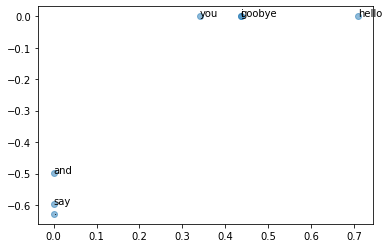

In [35]:
U, S, V=np.linalg.svd(ppmi_mat)

print(co_mat[0])
print(ppmi_mat[0])

print(U[0])


import matplotlib.pyplot as plt

for word, word_id in word_to_id.items():
    plt.annotate(word, (U[word_id, 0], U[word_id, 1]))

plt.scatter(U[:,0], U[:,1], alpha=0.5)
plt.show()

In [37]:
U[:,:2] #줄여진 표현!

array([[ 3.4094876e-01, -1.1102230e-16],
       [ 0.0000000e+00, -5.9763640e-01],
       [ 4.3631220e-01, -5.5511151e-17],
       [ 1.6653345e-16, -4.9782813e-01],
       [ 4.3631220e-01, -3.1237506e-17],
       [ 7.0923710e-01, -3.1237506e-17],
       [-1.6653345e-16, -6.2848860e-01]], dtype=float32)

# PTB dataset

In [38]:
import sys
sys.path.append("../book/")
from util import most_similar, create_co_matrix, ppmi

from dataset import ptb

window_size=2
wordvec_size=100

corpus, word_to_id, id_to_word=ptb.load_data("train")
vocab_size=len(word_to_id)
print("calculating sync happening matrix")

C=create_co_matrix(corpus, vocab_size, window_size)
print("Calculating PPMI")
W=ppmi(C, verbose=True)

print("Calculating SVD")

try:
    from sklearn.utils.extmath import randomized_svd
    U,S,V=randomized_svd(W, n_components=wordvec_size, n_iter=5, random_state=None)

except ImportError:
    U,S,V=np.linalg.svd(W)

word_vecs=U[:, :wordvec_size]

querys=['you', 'year', 'car', 'toyota']

for query in querys:
    most_similar(query, word_to_id, id_to_word, word_vecs, top=5)

calculating sync happening matrix
Calculating PPMI
1.0% complete
2.0% complete
3.0% complete
4.0% complete
5.0% complete
6.0% complete
7.0% complete
8.0% complete
9.0% complete
10.0% complete
11.0% complete
12.0% complete
13.0% complete
14.0% complete
15.0% complete
16.0% complete
17.0% complete
18.0% complete
19.0% complete
20.0% complete
21.0% complete
22.0% complete
23.0% complete
24.0% complete
25.0% complete
26.0% complete
27.0% complete
28.0% complete
29.0% complete
30.0% complete
31.0% complete
32.0% complete
33.0% complete
34.0% complete
35.0% complete
36.0% complete
37.0% complete
38.0% complete
39.0% complete
40.0% complete
41.0% complete
42.0% complete
43.0% complete
44.0% complete
45.0% complete
46.0% complete
47.0% complete
48.0% complete
49.0% complete
50.0% complete
51.0% complete
52.0% complete
53.0% complete
54.0% complete
55.0% complete
56.0% complete
57.0% complete
58.0% complete
59.0% complete
60.0% complete
61.0% complete
62.0% complete
63.0% complete
64.0% complet

In [41]:
word_vecs[word_to_id["you"]]

array([-3.3204213e-02, -2.3184963e-02, -4.5034070e-02, -7.0127800e-02,
        2.4159282e-02,  6.2005848e-02,  4.3695889e-02,  5.0263710e-02,
        3.1950075e-02, -4.4999357e-02,  5.4937869e-02,  2.5633902e-03,
        1.5639246e-02, -2.1372519e-02,  1.8986067e-02,  3.7703618e-02,
        2.9212892e-02, -1.8881964e-03,  1.9494103e-02, -8.7078195e-03,
        3.2171395e-03, -2.8452350e-02,  8.8799195e-03, -2.4427515e-02,
        3.5268564e-02, -6.2550366e-02,  1.9209838e-02, -2.2624819e-02,
       -9.1801519e-03,  1.5998490e-02, -2.5073487e-02, -3.4271125e-02,
       -4.3257838e-03,  9.7574824e-03, -1.4597591e-02, -3.2122382e-03,
        1.0502875e-02, -2.2090811e-02,  1.9812729e-02, -3.0579071e-02,
        2.2119859e-03,  4.5582555e-02, -2.7268168e-02,  4.3515142e-02,
        7.2897901e-03, -5.3543430e-03, -3.8376059e-02, -5.7572708e-03,
        4.8726521e-05,  1.0922983e-02,  3.7110668e-02, -1.6562868e-02,
       -4.2427450e-02, -3.2285163e-03,  2.2876345e-02,  6.1054109e-03,
      

In [42]:
vocab_size

10000